In [1]:
%load_ext autoreload
%autoreload 2

# Dataset

In [8]:
from matplotlib import pyplot as plt

import torch

# Code from SalsaNext: https://github.com/Halmstad-University/SalsaNext
from laserscan import LaserScan, SemLaserScan

from dataset import WADS
from dataloader import WADSLoader

In [9]:
wads = WADS("/tmp/wads_dataset/clean_dataset/", do_projection=True)

In [10]:
idx = 3
print(wads.scans[idx])
print(wads.labels[idx])

/tmp/wads_dataset/clean_dataset/24/velodyne/040911.bin
/tmp/wads_dataset/clean_dataset/24/labels/040911.label


In [11]:
proj_xyz, proj_range, proj_remission, label = wads[0]
print(proj_xyz.shape)
print(proj_range.shape)
print(proj_remission.shape)
print(label.shape)

torch.Size([3, 64, 1024])
torch.Size([1, 64, 1024])
torch.Size([1, 64, 1024])
torch.Size([97207, 2])


# Projection result

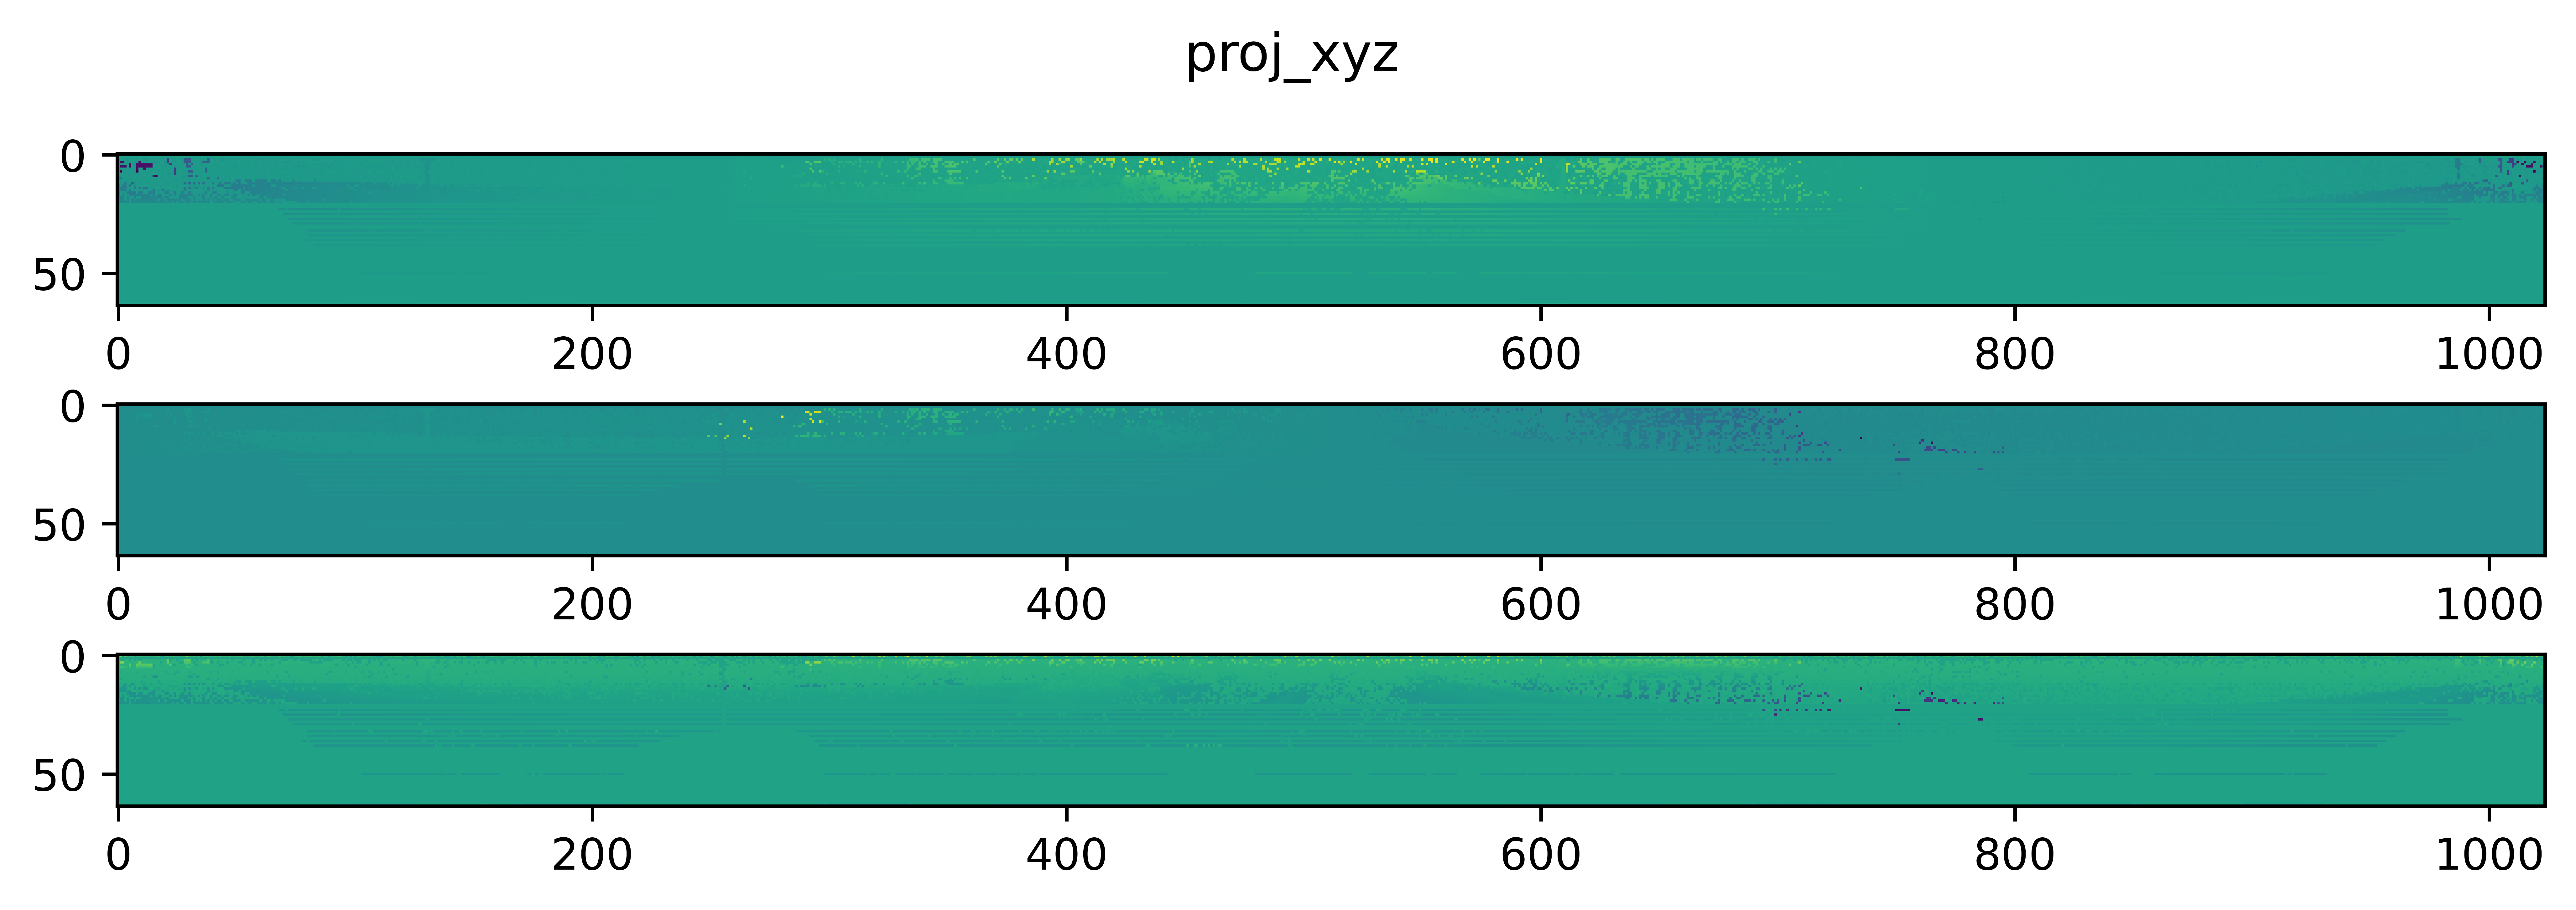

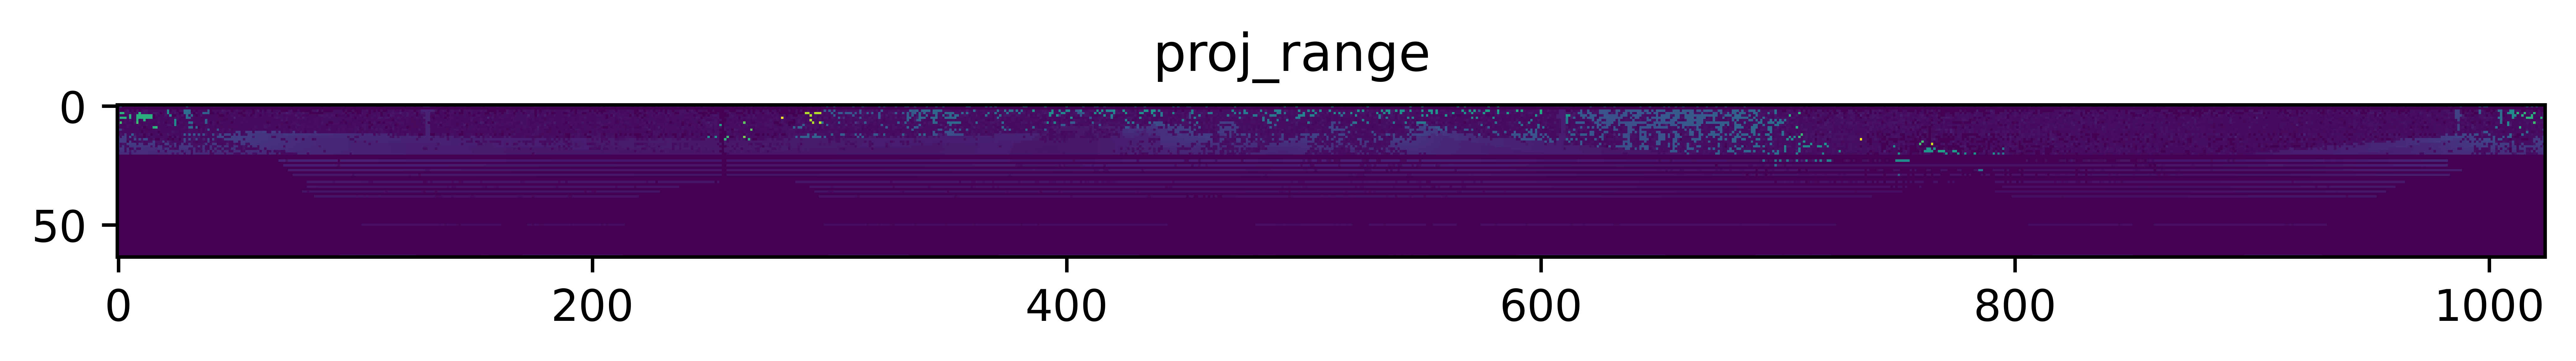

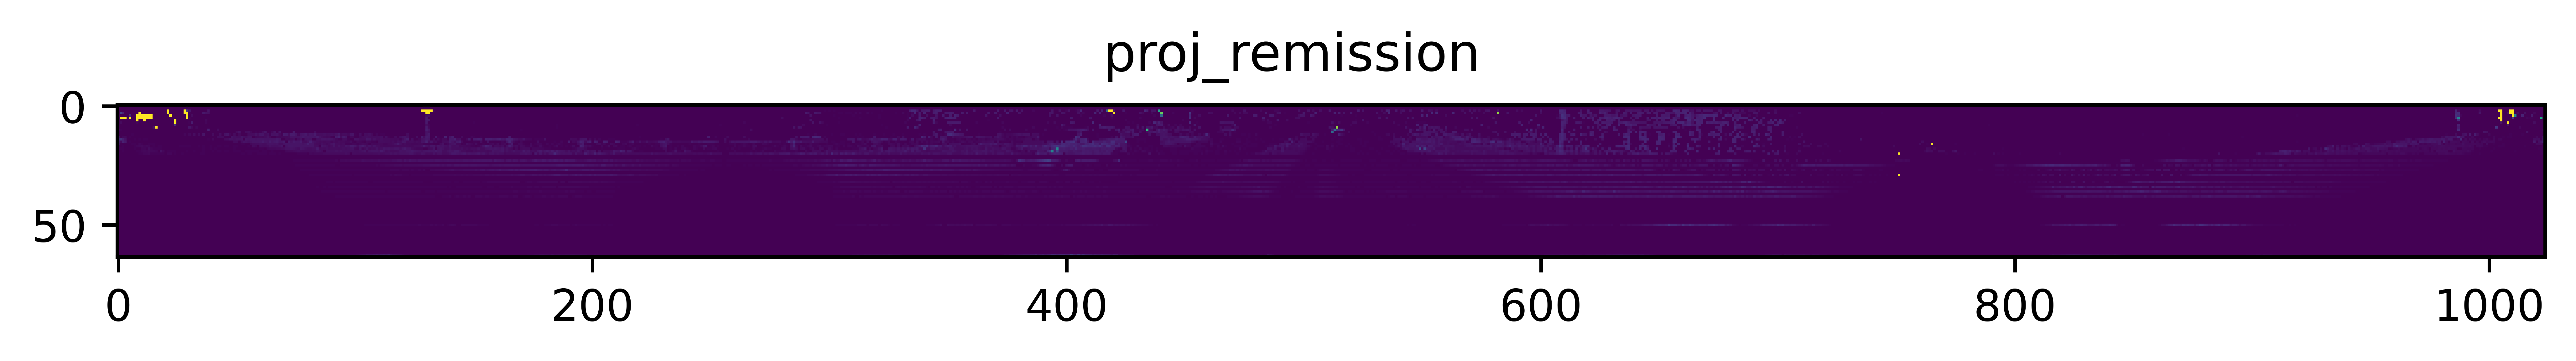

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 3), dpi=1000)
for i in range(3):
    axes[i].imshow(proj_xyz[i, :, :])
fig.suptitle("proj_xyz")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(proj_range))
fig.suptitle("proj_range")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(proj_remission))
fig.suptitle("proj_remission");
    

# Model

In [13]:
from weathernet import WeatherNet

In [14]:
batch_size = 16
hparams = {'train_ds': wads,
           'valid_ds': wads,
           'test_ds': wads,
           'batch_size': batch_size,
           'num_workers': 20
          }

wads_loader = WADSLoader(**hparams)

In [16]:
train_dataloader = wads_loader.train_dataloader()

In [22]:
# add label in return
proj_xyz, proj_range, proj_remission = next(iter(train_dataloader))

In [23]:
print(proj_xyz.shape)
print(proj_range.shape)
print(proj_remission.shape)

torch.Size([16, 3, 64, 1024])
torch.Size([16, 1, 64, 1024])
torch.Size([16, 1, 64, 1024])


In [24]:
wathernet = WeatherNet()

In [25]:
wathernet(proj_range, proj_remission).shape

torch.Size([16, 3, 64, 1024])